<h1> Week 5. Convolutional neural networks (CNN) </h1>

<h3>Import Pytorch libraries </h3>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

<h3> Load the CIFAR-10 dataset </h3>

In [ ]:
#from ipywidgets import IProgress
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
 
batch_size = 256
 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
 
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

<h3>Plot one batch of 32x32 images of the CIFAR-10 dataset</h3>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
f = plt.figure (figsize = (16,16))
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

<h1> Simple CNN architecture </h1>

<h3> Building a simple CNN architecture for the classifying images from the CIFAR-10</h3>

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x.to(device)
        return x


net = Net()

In [ ]:
!pip install torchviz
!pip install graphviz

<h3> Show a computation graph 

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\'
# print(os.environ["PATH"])
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
batch = next(iter(trainloader))
yhat = net(batch[0])
from torchviz import make_dot
make_dot(yhat, params=dict(list(net.named_parameters())))

<h3> Run on a CPU </h3>

In [ ]:
import torch.optim as optim
device = 'cpu'
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print (device)
net = net.to(device)

<h3> Run on  a single GPU </h3>

In [ ]:
import torch.optim as optim
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print (device)

<h3> Run parallel on Multiple GPUs </h3>

In [ ]:
import torch.optim as optim
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net, device_ids = [0,1])
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print (device)

In [ ]:
# Some additional information about hardware
print('torch.cuda.is_available():', torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('torch.device():', device)
current_device = torch.cuda.current_device()
print('torch.cuda.current_device():', current_device)
print('torch.cuda.device_count():', torch.cuda.device_count())
print('torch.cuda.get_device_name(current_device):', torch.cuda.get_device_name(current_device))

<h3> CNN training on a CIFAR-10 </h3>

In [ ]:
import time

start = time.time()

for epoch in range(15):  # loop over the dataset multiple times
# for epoch in range(40):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to (device)
        labels = labels.to (device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')
end = time.time()
print(end - start)

<h3> Visualize predictions </h3>

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(12)))

<h3> Calculate accuracy and other metrics </h3>

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

<h3> Calculate accuracy for each class separately </h3>

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

<h1>Alex-Net CNN architecture </h1>

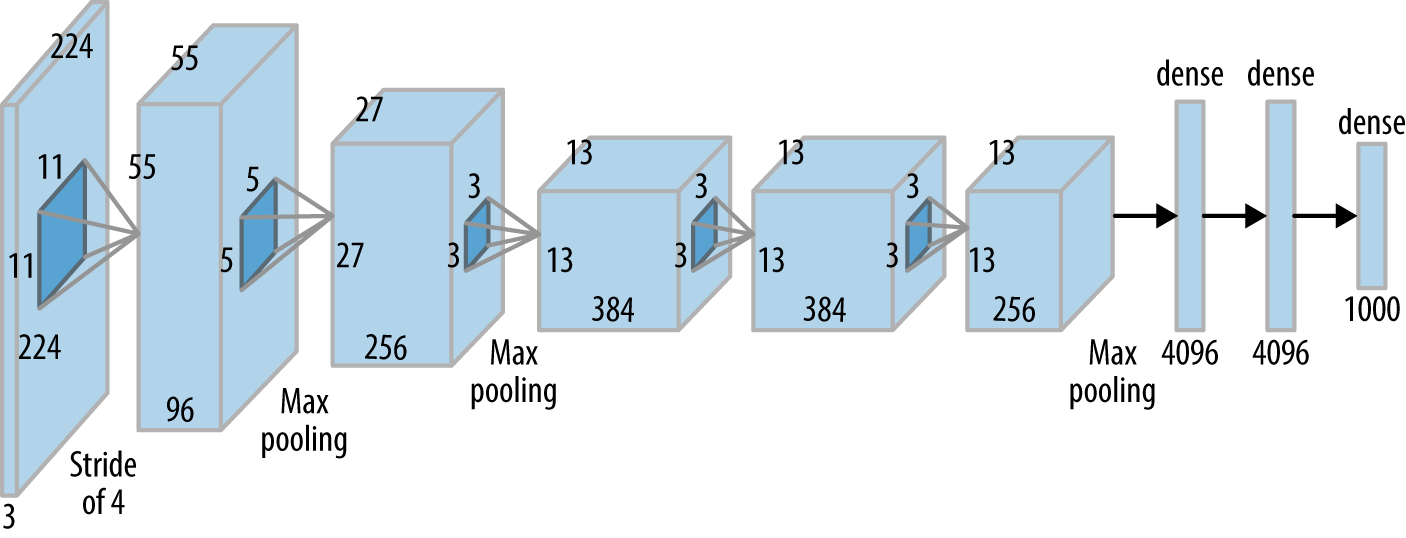

In [ ]:
NUM_CLASSES = 10
import torch.nn as nn
import torch.nn.functional as F
class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        x = x.to (device)
        return x

<h3> Alex-Net initialize the network loss and optimizer </h3>

In [ ]:
import torch.optim as optim
net = AlexNet ()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD (net.parameters(), lr=0.001, momentum=0.9)

<h3> Use available GPUs to perform training by using DataParallel package </h3>

In [ ]:
import torch.optim as optim
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net, device_ids = [0,1])
net.to(device)
print (device)

<h3> Run the training procedure for the CIFAR-10 dataset </h3>

In [ ]:
for epoch in range(15):  # loop over the dataset multiple times
# for epoch in range(200):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to (device)
        labels = labels.to (device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to (device)
        labels = labels.to (device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        if (total < 10):
            print (outputs, ' ', predicted, ' ', labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print (correct)
print (total)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to (device)
        labels = labels.to (device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

In [ ]:
import torchvision.models as models
resnet18 = models.resnet18()
alexnet = models.alexnet()
vgg16 = models.vgg16()
squeezenet = models.squeezenet1_0()
densenet = models.densenet161()
inception = models.inception_v3()
googlenet = models.googlenet()
shufflenet = models.shufflenet_v2_x1_0()
mobilenet_v2 = models.mobilenet_v2()
mobilenet_v3_large = models.mobilenet_v3_large()
mobilenet_v3_small = models.mobilenet_v3_small()
resnext50_32x4d = models.resnext50_32x4d()
wide_resnet50_2 = models.wide_resnet50_2()
mnasnet = models.mnasnet1_0()

<h1> Tasks for the lab </h1>

<h3> 1. Train the Alex-Net neural network with the use of Adam optimizer. Number of epochs should be 200, batch size - 256. Provide code for calculating accuracy values and the training loop for the given network in the box below. </h3>

In [ ]:
epochs = 20
#epochs = 200
batch_size = 256

In [ ]:
#from ipywidgets import IProgress
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
 
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
NUM_CLASSES = len(classes)
print('NUM_CLASSES:', NUM_CLASSES)

import torch.nn as nn
import torch.nn.functional as F
class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        x = x.to (device)
        return x

In [ ]:
import torch.optim as optim
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print (device)

net = AlexNet ()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
#put code for calculating accuracy here
import time

start = time.time()

print('Start traning.')
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 0:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')
print(time.time() - start)

<h3> Calculate accuracy and other metrics </h3>

In [ ]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (total, 100 * correct / total))

<h3> Calculate accuracy for each class separately </h3>

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

<h3> 2. Train the Alex-Net will the following changes:
    </h3>
    <ul>
        <li>Add Normalization of mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]</li>
        <li>Choose a random subset of 8 classes for the training/testing. </li>
        <li>Calculate the accurary and a confusion matrix for the given 8 classes</li>
    </ul>
    

In [1]:
import random
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

epochs = 20
#epochs = 200
batch_size = 256
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.ToTensor(), normalize])
picked_classes_idx = random.sample(range(0, 10), 8)
print('a random subset of 8 classes idx:', picked_classes_idx)


a random subset of 8 classes idx: [1, 3, 6, 5, 8, 4, 9, 0]


Files already downloaded and verified
[1, 3, 6, 5, 8, 4, 9, 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


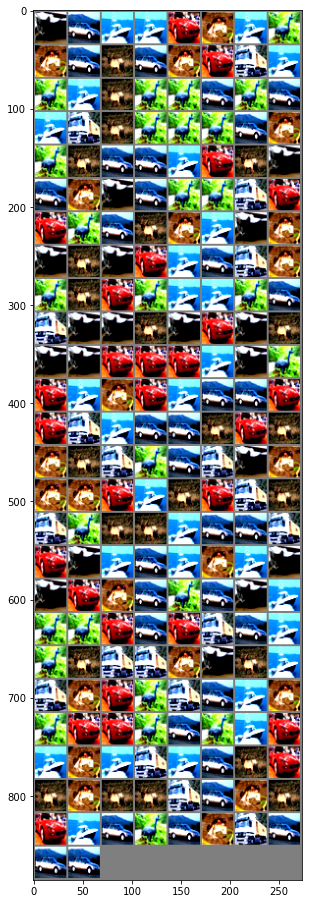

  cat   car  ship  ship   car  frog  ship  bird  frog   car  deer   car  frog   car truck  ship  bird  ship  deer  bird  bird   car  bird   car  ship truck  deer  bird  bird  bird   car  frog  bird  deer   car   car  ship   car  deer   cat   car  frog   cat   car  bird  bird truck   car   car  bird   car  deer  frog  ship   cat  frog   cat  deer   cat   car  ship   car truck  frog  bird  deer   car  bird  ship  ship  bird   car truck   cat   cat  deer   cat   car   cat  deer   cat   cat   car   car   car  ship   cat  bird   car  ship  frog   car  ship   car   car   car   car truck  ship   car   car  deer   car  deer  frog  deer truck  bird   car truck   cat  frog  frog  frog   car  ship  deer   car truck  deer truck  bird  deer  deer  ship   car   car truck   car   cat  ship   car  ship  frog  ship   cat   cat   car  frog   car  bird   car   cat  ship  bird  bird   car   car   car truck   car  ship  bird  deer truck truck  frog   cat  deer  ship truck  frog   car  bird truck   car  shi

In [2]:
# Return only images of certain class (eg. aeroplanes = class 0)
def get_idx(v_dataset_label, v_picked_classes_idx):
    print(picked_classes_idx)
    return [v_dataset_label[i] for i in range(len(v_dataset_label)) if v_dataset_label[i] in v_picked_classes_idx]

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#Load TrainSet
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

dataiter = iter(trainloader)
images, labels = dataiter.next()

train_indices=get_idx(labels, picked_classes_idx)
current_train_set = torch.utils.data.Subset(trainset, train_indices)
current_train_trainloader = torch.utils.data.DataLoader(current_train_set, batch_size=batch_size, shuffle=True, num_workers=2)
dataiter = iter(current_train_trainloader)
current_train_images, current_train_labels = dataiter.next()

f = plt.figure (figsize = (16,16))
# show images
imshow(torchvision.utils.make_grid(current_train_images))
# print labels
print(' '.join('%5s' % classes[current_train_labels[j]] for j in range(len(current_train_labels))))

In [3]:
# NUM_CLASSES = len(picked_classes_idx)
NUM_CLASSES = 10
print('NUM_CLASSES:', NUM_CLASSES)

import torch.nn as nn
import torch.nn.functional as F
class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        x = x.to(device)
        return x

NUM_CLASSES: 10


In [4]:
import torch.optim as optim
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print (device)

net_t2 = AlexNet()
net_t2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_t2.parameters(), lr=0.001)

cuda:0


In [5]:
import time

start = time.time()

print('Start traning.')
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(current_train_trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_t2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 0:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')
print(time.time() - start)

Start traning.


C:\Users\user\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,     1] loss: 0.046
[2,     1] loss: 0.039
[3,     1] loss: 0.042
[4,     1] loss: 0.036
[5,     1] loss: 0.040
[6,     1] loss: 0.040
[7,     1] loss: 0.041
[8,     1] loss: 0.040
[9,     1] loss: 0.040
[10,     1] loss: 0.039
[11,     1] loss: 0.038
[12,     1] loss: 0.035
[13,     1] loss: 0.031
[14,     1] loss: 0.029
[15,     1] loss: 0.023
[16,     1] loss: 0.020
[17,     1] loss: 0.018
[18,     1] loss: 0.019
[19,     1] loss: 0.008
[20,     1] loss: 0.007
Finished Training
88.48547863960266


Files already downloaded and verified
[0, 7, 9, 8, 1, 6, 3, 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


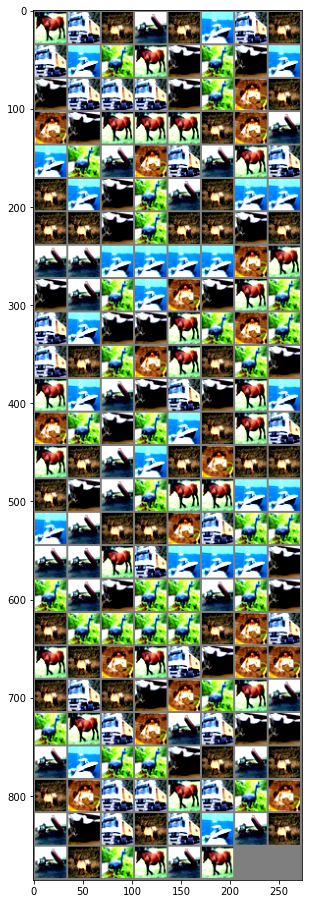

GroundTruth:  horse truck  deer truck  deer  ship truck  deer truck  ship  bird horse   cat  bird   cat  ship   cat truck truck truck   cat  bird  frog  deer  frog   cat horse horse horse  deer  frog truck  ship  bird truck  frog truck truck horse truck  deer  ship   cat  bird truck  deer  ship  ship  deer  deer   cat  bird  deer  deer   cat  deer truck truck  ship  ship  ship  ship  frog horse   cat truck  bird  ship  frog   cat horse  bird truck  ship   cat   cat horse  bird  frog  bird truck  deer  bird  frog horse  deer  bird   cat horse  ship truck   cat truck   cat horse  ship  frog  bird   cat  bird  ship  deer horse truck horse  deer truck  ship  deer  frog  deer  deer  deer   cat truck  bird horse horse  ship  ship  ship truck  deer  deer  frog truck  bird  bird truck truck horse truck  ship  ship  ship   cat  bird truck   cat  bird  bird truck  bird   cat  deer  bird  bird  bird  bird  deer  frog truck horse  deer  frog horse truck   cat  frog  frog  deer truck  deer   cat  f

In [3]:
# Load TestSet
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

dataiter = iter(testloader)
images, labels = dataiter.next()

test_indices=get_idx(labels, picked_classes_idx)
current_test_set = torch.utils.data.Subset(trainset, train_indices)
current_testloader = torch.utils.data.DataLoader(current_test_set, batch_size=batch_size, shuffle=True, num_workers=2)
dataiter = iter(current_testloader)
current_test_images, current_test_labels = dataiter.next()

f = plt.figure (figsize = (16,16))
# print images
imshow(torchvision.utils.make_grid(current_test_images))
print('GroundTruth: ', ' '.join('%5s' % classes[current_test_labels[j]] for j in range(len(current_test_labels))))

In [ ]:
# Load TestSet
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

dataiter = iter(testloader)
images, labels = dataiter.next()

test_indices=get_idx(labels, picked_classes_idx)
current_test_set = torch.utils.data.Subset(trainset, train_indices)
current_testloader = torch.utils.data.DataLoader(current_test_set, batch_size=batch_size, shuffle=True, num_workers=2)
dataiter = iter(current_testloader)
current_test_images, current_test_labels = dataiter.next()

f = plt.figure (figsize = (16,16))
# print images
imshow(torchvision.utils.make_grid(current_test_images))
print('GroundTruth: ', ' '.join('%5s' % classes[current_test_labels[j]] for j in range(len(current_test_labels))))

<h3> Calculate accuracy and other metrics </h3>

In [ ]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (total, 100 * correct / total))

<h3> Calculate accuracy for each class separately </h3>

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

<h3> 3. From the torchvision module import models and compare performances of VGG-16, resnet-18 and Alex-Net on a CIFAR-10 dataset </h3>

In [ ]:
import torchvision.models as models
vgg16 = models.vgg16()
resnet18 = models.resnet18()
alexnet = models.alexnet()
